In [9]:
import pandas as pd
import os
import numpy as np
from google.colab import drive
drive.mount("content")

DIR = "content/MyDrive/cz4032 data mining/Proj 2"
INPUT_DIR = os.path.join(DIR, "input")
OUTPUT_DIR = os.path.join(DIR, "output")

df = pd.read_csv(os.path.join(INPUT_DIR, "players_22.csv"))
df_original = pd.read_csv(os.path.join(INPUT_DIR, "players_22.csv"))
df_processed = pd.read_csv(os.path.join(INPUT_DIR, "processed_fifa.csv"))
results_df = pd.read_csv(os.path.join(OUTPUT_DIR, "itemsets_0.01_threshold.csv"))

Drive already mounted at content; to attempt to forcibly remount, call drive.mount("content", force_remount=True).


<ipython-input-9-9cb57ce736fa>:11: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(INPUT_DIR, "players_22.csv"))
<ipython-input-9-9cb57ce736fa>:12: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original = pd.read_csv(os.path.join(INPUT_DIR, "players_22.csv"))


## Processing and apriori

In [3]:
url_cols = df.filter(like="_url").columns.to_list()
id_cols = ['sofifa_id', 'short_name', 'long_name','nation_team_id','nationality_id','club_team_id',]
rating_as_pos = ['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk']
jersey_cols = ['nation_jersey_number','club_jersey_number',]
date_cols = ['release_clause_eur','club_contract_valid_until','club_joined','dob']
wage_cols = ['value_eur', 'wage_eur',]
misc_cols = ['real_face','club_loaned_from', 'league_level', 'club_position', 'nation_position','club_name', 'league_name','potential','preferred_foot', 'weak_foot','player_positions','overall', 'international_reputation', 'body_type']

drop_cols = url_cols+id_cols+rating_as_pos+jersey_cols+date_cols+misc_cols+wage_cols
df = df.drop(columns=drop_cols)

In [4]:
attribute_categories = ['goalkeeping', 'defending', 'mentality', 'power', 'movement', 'skill', 'attacking']
attr_means = []
aggregated_base_cols = []
for attr_cat in attribute_categories:
    aggregate = df.filter(like=attr_cat)
    print(aggregate.columns)
    aggregated_base_cols.extend(aggregate.columns.to_list())
    attr_mean = aggregate.mean(axis=1)
    attr_mean.name = attr_cat
    attr_means.append(attr_mean)
df = df.drop(columns = aggregated_base_cols)
new_aggregated_cols = pd.concat(attr_means, axis=1)
df = pd.concat([df, new_aggregated_cols], axis = 1)

Index(['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed'],
      dtype='object')
Index(['defending', 'defending_marking_awareness', 'defending_standing_tackle',
       'defending_sliding_tackle'],
      dtype='object')
Index(['mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure'],
      dtype='object')
Index(['power_shot_power', 'power_jumping', 'power_stamina', 'power_strength',
       'power_long_shots'],
      dtype='object')
Index(['movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance'],
      dtype='object')
Index(['skill_moves', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy',
       'skill_long_passing', 'skill_ball_control'],
      dtype='object')
Index(['attacking_crossing', 'attacking_finishing',
       'attacking

In [5]:
## Feature Discretization using quantiles

columns_to_bucket = df.select_dtypes(np.number)

## Use the cut function to create 3 quantile-based buckets
## Specify the number of bins (3 in this case) to create
for col in columns_to_bucket:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)

    bucket_edges = [df[col].min()-1, q1, q3, df[col].max()+1]
    category_labels = ['low', 'medium', 'high']

    # Use the cut function to create 3 IQR-based buckets
    df[f'{col}_bucket'] = pd.cut(df[col], bins=bucket_edges, labels=category_labels)
df = df.drop(columns = columns_to_bucket)

In [ ]:
df['work_rate'] = df['work_rate'].apply(lambda x: x.lower().split("/")[0])
df['player_tags'] = df['player_tags'].fillna("NONE")
df['player_tags'] = df['player_tags'].apply(lambda x: [i.replace("#", "").strip() for i in x.lower().split(",")])
df['player_traits'] = df['player_traits'].fillna("NONE")
df['player_traits'] = df['player_traits'].apply(lambda x: [i.strip() for i in x.lower().split(",")])

In [ ]:
def create_transactions(df):
    data = []
    for i in range(df.shape[0]):
        row = df.iloc[i]
        feature_row = []
        for col in df.columns:
            feature = row[col]
            if isinstance(feature, list):
                features = [f"{col}_{f}" for f in feature]
            else:
                features = [f"{col}_{feature}"]
            feature_row.extend(features)
            feature_row = [f for f in feature_row if ("none" not in f and "nan" not in f)]
        data.append(feature_row)
    return data

df2 = df[['player_tags', 'player_traits','passing_bucket', 'physic_bucket','pace_bucket','mentality_bucket', 'movement_bucket']]
data = create_transactions(df2)

In [ ]:
from collections import defaultdict
import itertools

# candidate generation
class Apriori:
    def __init__(self, transactions, min_support=0.1, min_confidence=0.5):
        self.transactions = transactions
        self.min_support = min_support
#         self.min_confidence = min_confidence
        self.itemsets = defaultdict(int)
        self.hash_buckets = defaultdict(int)
        self.num_transactions = len(transactions)
        self.frequent_itemsets = []

    def _generate_candidate_itemsets(self, prev_frequent_itemsets, k):
        candidates = set()
        for itemset1 in prev_frequent_itemsets:
            for itemset2 in prev_frequent_itemsets:
                new_candidate = itemset1.union(itemset2)
                if len(new_candidate) == k:
                    all_subsets_are_frequent = all([frozenset(subset) in prev_frequent_itemsets for subset in itertools.combinations(new_candidate, k-1)])
                    if all_subsets_are_frequent:
                        candidates.add(new_candidate)
        return candidates

    def _apply_pcy(self):
        #first pass: count the pairs in each bucket
        for transaction in self.transactions:
            for pair in itertools.combinations(sorted(transaction), 2):  # Sorting ensures consistent order
                bucket = hash(pair) % 10000
                self.hash_buckets[bucket] += 1

        #determine the frequent buckets
        bucket_threshold = self.min_support * self.num_transactions  # Using raw counts instead of ratios for bucket threshold
        self.hash_buckets = {bucket for bucket, count in self.hash_buckets.items() if count >= bucket_threshold}

    def run(self):
        self._apply_pcy() # pcy in first pass
        for transaction in self.transactions:
            for item in transaction:
                self.itemsets[frozenset([item])] += 1

        #filter frequent 1-itemsets
        self.frequent_itemsets = [(itemset, count / self.num_transactions) for itemset, count in self.itemsets.items() if count / self.num_transactions >= self.min_support]

        k = 2
        while True:
            candidates = self._generate_candidate_itemsets([item[0] for item in self.frequent_itemsets], k) # generate candidates
            if k == 2:  #pcy only applicable for pairs in the second pass
                candidates = [candidate for candidate in candidates if hash(tuple(sorted(candidate))) % 10000 in self.hash_buckets]
            candidate_counts = defaultdict(int)
            for transaction in self.transactions:
                for candidate in candidates:
                    if candidate.issubset(transaction):
                        candidate_counts[candidate] += 1

            #filter frequent itemsets
            new_frequent_itemsets = [(itemset, count / self.num_transactions) for itemset, count in candidate_counts.items() if count / self.num_transactions >= self.min_support]

            if not new_frequent_itemsets:
                break

            self.frequent_itemsets.extend(new_frequent_itemsets)
            k += 1

        return self.frequent_itemsets

In [ ]:
def print_results(results):
    print("Num itemsets", len(results))
    print("Largest size", len(max(results, key = lambda x: len(x[0]))[0]))

import time

start = time.time()

apriori = Apriori(data, min_support=0.01)
results = apriori.run()

end = time.time()

print(end-start)
print_results(results)

In [ ]:
processed_fifa = pd.DataFrame([data]).transpose()
processed_fifa.columns = ["text"]
processed_fifa.to_csv(os.path.join(DIR, "processed_fifa.csv"), index=False)

itemsets = [i[0] for i in results]
sup = [i[1] for i in results]
result_df = pd.DataFrame({"itemsets": itemsets, "support": sup})
result_df.to_csv(os.path.join(DIR, "itemsets_0.01_threshold.csv"), index=False)

## Fp growth

In [ ]:
from fpgrowth import FP_Growth

fp_growth = FP_Growth(data, min_support=0.2)
start = time.time()
frequent_itemsets = fp_growth.run()
end = time.time()
print(end-start)
print(len(frequent_itemsets))
print(max([len(itemset[0]) for itemset in frequent_itemsets]))

## Clustering

In [10]:
df_processed['wage_eur'] = df_original['wage_eur']
df_processed = df_processed.dropna(subset = 'wage_eur').reset_index(drop=True)

In [11]:
df_processed

,text,wage_eur
0,"['player_tags_dribbler', 'player_tags_distance...",320000.0
1,"['player_tags_aerial threat', 'player_tags_dis...",270000.0
2,"['player_tags_aerial threat', 'player_tags_dri...",270000.0
3,"['player_tags_speedster', 'player_tags_dribble...",270000.0
4,"['player_tags_dribbler', 'player_tags_playmake...",350000.0
...,...,...
19173,"['passing_bucket_low', 'physic_bucket_low', 'p...",1000.0
19174,"['passing_bucket_low', 'physic_bucket_low', 'p...",500.0
19175,"['passing_bucket_low', 'physic_bucket_low', 'p...",500.0
19176,"['passing_bucket_low', 'physic_bucket_low', 'p...",500.0


In [12]:
## Feature Discretization using quantiles

columns_to_bucket = ["wage_eur"]

## Use the cut function to create 3 quantile-based buckets
## Specify the number of bins (3 in this case) to create
for col in columns_to_bucket:
    q1 = df_processed[col].quantile(0.25)
    q3 = df_processed[col].quantile(0.75)

    bucket_edges = [df_processed[col].min()-1, q1, q3, df_processed[col].max()+1]
    category_labels = ['low', 'medium', 'high']

    # # Use the cut function to create 3 IQR-based buckets
    df_processed[f'{col}_bucket'] = pd.cut(df_processed[col], bins=bucket_edges, labels=category_labels)

df_processed = df_processed.drop(columns = columns_to_bucket)

In [ ]:
import ast

transactions = df_processed['text'].to_list()
transactions = [ast.literal_eval(i) for i in transactions]
frequent_itemsets = [eval(i) for i in results_df['itemsets'].to_list()]

In [ ]:
def get_binary_matrix(transactions, frequent_itemsets, k=2):
    frequent_itemsets = [i for i in frequent_itemsets if len(i)>=k]
    matrix = np.ones((len(transactions), len(frequent_itemsets)))
    for i, transaction in enumerate(transactions):
        for j, itemset in enumerate(frequent_itemsets):
            for item in itemset:
                if item not in transaction:
                    matrix[i][j] = 0
                    break

    return matrix, frequent_itemsets

m, itemsets = get_binary_matrix(transactions, frequent_itemsets, k = 1)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert dictionaries to DataFrames
def plot_cluster_dists(label0, label1, label2):

    df0 = pd.DataFrame(list(label0.items()), columns=['Bucket', 'Value'])
    df0['Label'] = 'Cluster 0'

    df1 = pd.DataFrame(list(label1.items()), columns=['Bucket', 'Value'])
    df1['Label'] = 'Cluster 1'

    df2 = pd.DataFrame(list(label2.items()), columns=['Bucket', 'Value'])
    df2['Label'] = 'Cluster 2'



    # Concatenate DataFrames
    df_plot = pd.concat([df0, df1, df2])

    # Set the style for the plot (optional)
    sns.set(style="whitegrid")

    # Create a hued bar plot using seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Label', y='Value', hue='Bucket', data=df_plot)

    # Set plot labels and title
    plt.xlabel("Cluster")
    plt.ylabel("Value")
    plt.title("Distribution of wage buckets per cluster")

    # Show the plot
    plt.show()


In [ ]:
features = pd.DataFrame(m, columns = itemsets)

In [ ]:
df_with_features = pd.concat([df_processed, features], axis=1).drop(columns="text")
df_with_features

,wage_eur_bucket,(player_tags_acrobat),(player_traits_finesse shot),(player_traits_long shot taker (ai)),(player_traits_playmaker (ai)),(player_traits_outside foot shot),(player_traits_technical dribbler (ai)),(passing_bucket_high),(physic_bucket_medium),(pace_bucket_high),...,"(pace_bucket_medium, physic_bucket_low, movement_bucket_high, mentality_bucket_medium, passing_bucket_medium)","(movement_bucket_low, passing_bucket_low, physic_bucket_medium, mentality_bucket_low, pace_bucket_low)","(passing_bucket_low, pace_bucket_medium, mentality_bucket_low, physic_bucket_low, movement_bucket_medium)","(passing_bucket_low, pace_bucket_medium, physic_bucket_low, mentality_bucket_medium, movement_bucket_medium)","(physic_bucket_low, mentality_bucket_medium, pace_bucket_low, movement_bucket_medium, passing_bucket_medium)","(passing_bucket_low, physic_bucket_medium, pace_bucket_medium, mentality_bucket_low, movement_bucket_medium)","(pace_bucket_medium, mentality_bucket_low, physic_bucket_low, movement_bucket_medium, passing_bucket_medium)","(movement_bucket_low, passing_bucket_low, mentality_bucket_low, physic_bucket_low, pace_bucket_low)","(physic_bucket_medium, mentality_bucket_medium, player_traits_speed dribbler (ai), movement_bucket_high, pace_bucket_high, passing_bucket_medium)","(mentality_bucket_medium, physic_bucket_low, player_traits_speed dribbler (ai), movement_bucket_high, pace_bucket_high, passing_bucket_medium)"
0,high,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,high,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,high,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,high,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,high,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19173,low,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19174,low,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19175,low,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19176,low,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.cluster import KMeans

X_train = df_with_features.drop(columns=['wage_eur_bucket', 'labels'])

kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X_train)
df_with_features['labels'] = kmeans.labels_

In [ ]:
df_with_features['labels'].value_counts()

1    14105
0     3447
2     1626
Name: labels, dtype: int64

In [ ]:
from collections import Counter
from scipy.stats import entropy

def get_wage_distribution(cluster_df):
    counts = Counter(cluster_df['wage_eur_bucket'].to_list())
    total_count = sum(counts.values())
    return {
        wage: count / total_count for wage, count in counts.items()
    }

def get_entropy(wage_distribution):
    return entropy(list(wage_distribution.values()))

In [ ]:
label1 = get_wage_distribution(df_with_features.loc[df_with_features['labels']==1])
label2 = get_wage_distribution(df_with_features.loc[df_with_features['labels']==2])
label0 = get_wage_distribution(df_with_features.loc[df_with_features['labels']==0])
e0 = get_entropy(label0)
e1 = get_entropy(label1)
e2 = get_entropy(label2)
print("Entropy for label0:", e0)
print("Entropy for label1:", e1)
print("Entropy for label2:", e2)
print(np.average([e1,e2,e0]))

Entropy for label0: 0.7966978356918072
Entropy for label1: 1.011906480515778
Entropy for label2: 0.9135769239596778
0.907393746722421


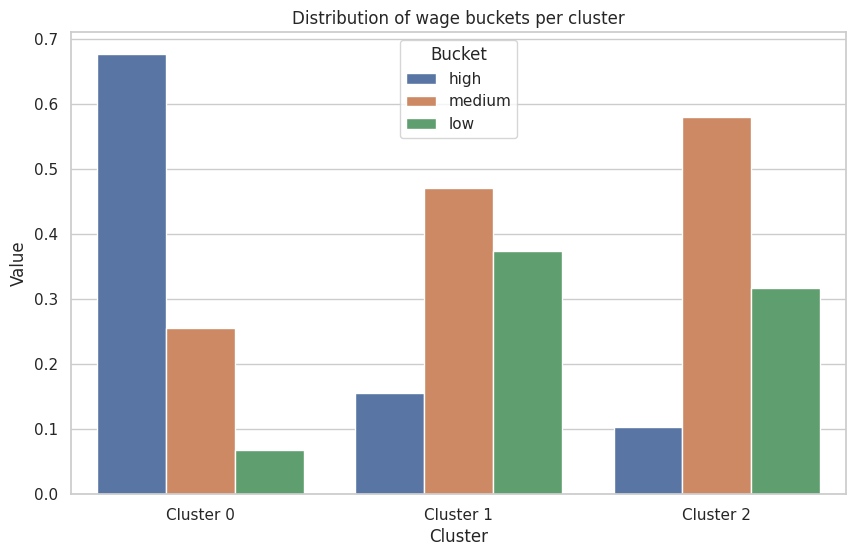

In [ ]:
plot_cluster_dists(label0, label1, label2)

## Task 4 improvement

In [ ]:
!pip install umap-learn -q

In [ ]:
mapping = results_df.set_index('itemsets')['support'].to_dict()

mapping = {eval(key): value for key, value in mapping.items()}

support_df = df_with_features.copy()
for col in support_df.columns:
    support_value = mapping.get(col)
    if support_value is not None:
        support_df[col] = support_df[col].apply(lambda x: support_value if x == 1 else x)

support_df

,wage_eur_bucket,(player_tags_acrobat),(player_traits_finesse shot),(player_traits_long shot taker (ai)),(player_traits_playmaker (ai)),(player_traits_outside foot shot),(player_traits_technical dribbler (ai)),(passing_bucket_high),(physic_bucket_medium),(pace_bucket_high),...,"(movement_bucket_low, passing_bucket_low, physic_bucket_medium, mentality_bucket_low, pace_bucket_low)","(passing_bucket_low, pace_bucket_medium, mentality_bucket_low, physic_bucket_low, movement_bucket_medium)","(passing_bucket_low, pace_bucket_medium, physic_bucket_low, mentality_bucket_medium, movement_bucket_medium)","(physic_bucket_low, mentality_bucket_medium, pace_bucket_low, movement_bucket_medium, passing_bucket_medium)","(passing_bucket_low, physic_bucket_medium, pace_bucket_medium, mentality_bucket_low, movement_bucket_medium)","(pace_bucket_medium, mentality_bucket_low, physic_bucket_low, movement_bucket_medium, passing_bucket_medium)","(movement_bucket_low, passing_bucket_low, mentality_bucket_low, physic_bucket_low, pace_bucket_low)","(physic_bucket_medium, mentality_bucket_medium, player_traits_speed dribbler (ai), movement_bucket_high, pace_bucket_high, passing_bucket_medium)","(mentality_bucket_medium, physic_bucket_low, player_traits_speed dribbler (ai), movement_bucket_high, pace_bucket_high, passing_bucket_medium)",labels
0,high,0.018036,0.034305,0.079318,0.047872,0.032018,0.08805,0.213421,0.436249,0.194605,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
1,high,0.000000,0.034305,0.000000,0.000000,0.032018,0.00000,0.213421,0.000000,0.194605,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
2,high,0.018036,0.000000,0.079318,0.000000,0.032018,0.00000,0.213421,0.000000,0.194605,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
3,high,0.018036,0.000000,0.000000,0.047872,0.032018,0.08805,0.213421,0.436249,0.194605,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
4,high,0.000000,0.000000,0.079318,0.047872,0.032018,0.00000,0.213421,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19173,low,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1
19174,low,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1
19175,low,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.011071,0.0,0.0,1
19176,low,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.0,0.032174,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1


In [ ]:
X_support = support_df.drop(columns=['wage_eur_bucket', 'labels'])
k = 2
cols = [i for i in X_support.columns if len(i)>=k]
X_support = X_support[cols].to_numpy()

In [ ]:
X_bits = df_with_features.drop(columns=['wage_eur_bucket', 'labels'])
k = 2
cols = [i for i in X_bits.columns if len(i)>=k]
X_bits = X_bits[cols].to_numpy()

In [ ]:
from sklearn.decomposition import PCA, TruncatedSVD
from scipy import sparse
import umap.umap_ as umap

def get_optimal_pca_components(df, min_explained_var=0.95):
    pca = PCA().fit(df)
    cum_sum_explained_var = np.cumsum(pca.explained_variance_ratio_)
    min_num_components = np.where(cum_sum_explained_var>=min_explained_var)[0][0] + 1
    return min_num_components

def apply_umap(matrix, n_components=10, random_state=0):
    np.random.seed(random_state)
    matrix = sparse.csr_matrix(matrix)
    return umap.UMAP(n_components=n_components, random_state=random_state, metric='jaccard').fit_transform(matrix)

def apply_svd(matrix, n_components=10, random_state=0):
    return TruncatedSVD(n_components=n_components, random_state=random_state).fit_transform(matrix)


In [ ]:
# optimal_components = get_optimal_pca_components(X)
# X_train = PCA(n_components=optimal_components).fit_transform(X)

# X_umap = pd.DataFrame(apply_umap(X_bits, n_components=50)).dropna()
# res_df = support_df.iloc[X_umap.index].copy()

X_svd = pd.DataFrame(apply_svd(X_bits, n_components=100)).dropna()
res_df = support_df.iloc[X_svd.index].copy()

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X_svd)
res_df['labels'] = kmeans.labels_

In [ ]:
label1 = get_wage_distribution(res_df.loc[res_df['labels']==1])
label2 = get_wage_distribution(res_df.loc[res_df['labels']==2])
label0 = get_wage_distribution(res_df.loc[res_df['labels']==0])
e0 = get_entropy(label0)
e1 = get_entropy(label1)
e2 = get_entropy(label2)
print("Entropy for label0:", e0)
print("Entropy for label1:", e1)
print("Entropy for label2:", e2)
print(np.average([e1,e2,e0]))

Entropy for label0: 0.7309061713670828
Entropy for label1: 1.0371607694148042
Entropy for label2: 0.7990306337231443
0.8556991915016772


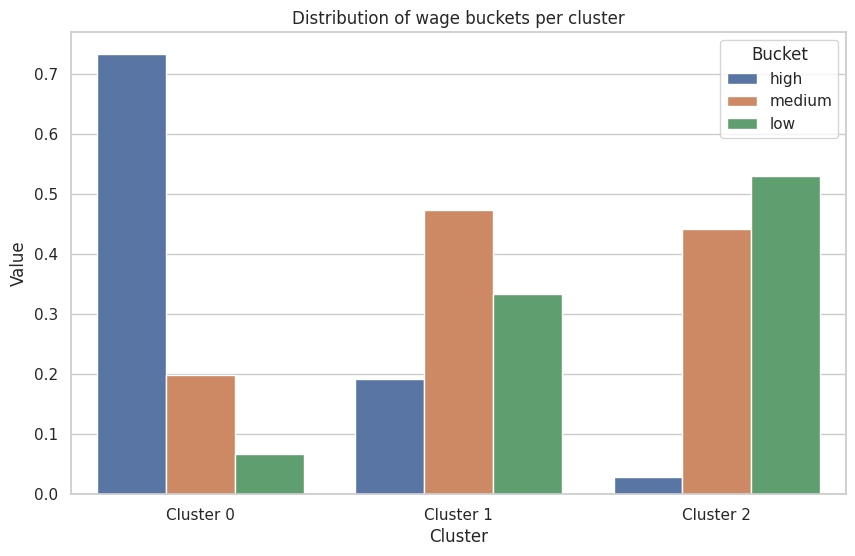

In [ ]:
plot_cluster_dists(label0, label1, label2)

## top itemsets per cluster

In [ ]:
df_with_features['labels'] = res_df['labels']

In [ ]:
long_features = df_with_features.drop(columns="wage_eur_bucket").melt(id_vars='labels')
long_features = long_features.loc[long_features['value']==1]
long_features

,labels,variable,value
0,0,(player_tags_acrobat),1.0
2,0,(player_tags_acrobat),1.0
3,0,(player_tags_acrobat),1.0
6,0,(player_tags_acrobat),1.0
13,0,(player_tags_acrobat),1.0
...,...,...,...
21801356,1,"(mentality_bucket_medium, physic_bucket_low, p...",1.0
21801623,1,"(mentality_bucket_medium, physic_bucket_low, p...",1.0
21801709,1,"(mentality_bucket_medium, physic_bucket_low, p...",1.0
21801922,1,"(mentality_bucket_medium, physic_bucket_low, p...",1.0


In [ ]:
def get_top_itemsets_per_cluster(df):
    labels = df['labels'].unique()
    cluster_itemcounts = {}
    for l in labels:
        traits = df.loc[df['labels']==l, 'variable'].to_list()
        counts = Counter(traits)
        cluster_itemcounts[l] = counts
    return cluster_itemcounts

In [ ]:
itemcounts = get_top_itemsets_per_cluster(long_features)

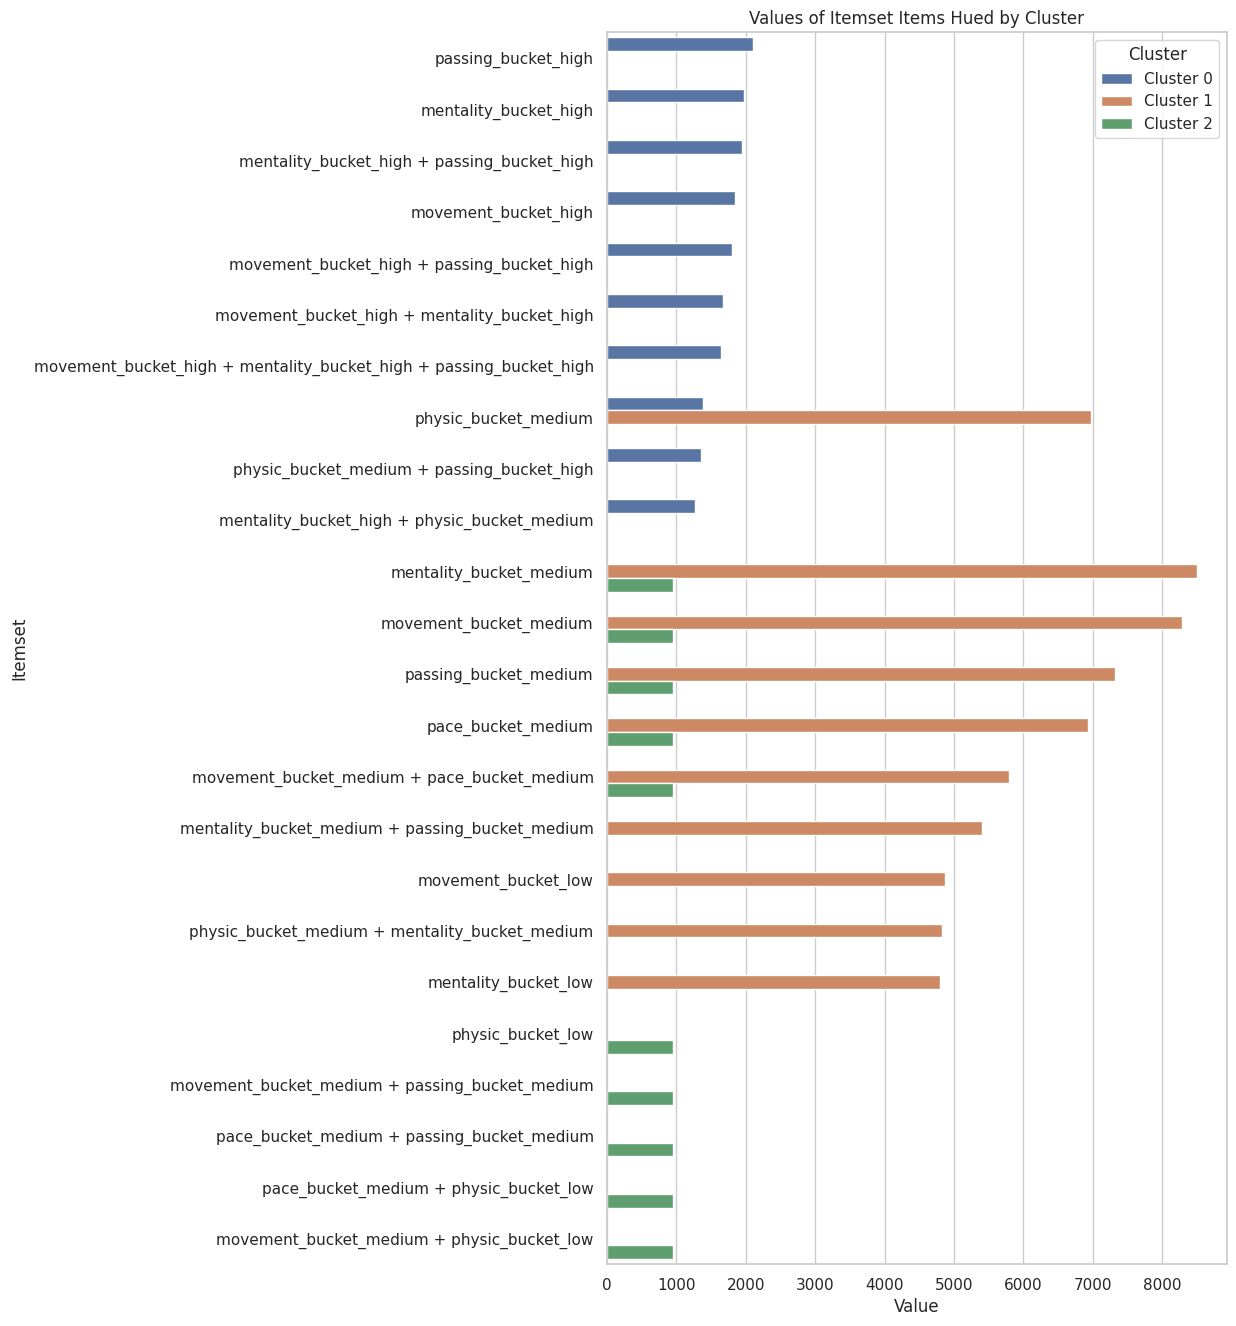

In [ ]:
k = 10
# Convert data to DataFrame
data = []
label0 = sorted(itemcounts[0].items(), key = lambda x: -x[1])[:k]
label1 = sorted(itemcounts[1].items(), key = lambda x: -x[1])[:k]
label2 = sorted(itemcounts[2].items(), key = lambda x: -x[1])[:k]

for label, values in [('Cluster 0', label0), ('Cluster 1', label1), ('Cluster 2', label2)]:
    for frozenset_item, value in values:
        data.append({'Cluster': label, 'Itemset': ' + '.join(frozenset_item), 'Value': value})

df = pd.DataFrame(data)

# Set the style for the plot (optional)
sns.set(style="whitegrid")

# Create a hued bar plot using seaborn
plt.figure(figsize=(8, 16))
sns.barplot(y='Itemset', x='Value', hue='Cluster', data=df)

# Set plot labels and title
plt.xlabel("Value")
plt.ylabel("Itemset")
plt.title("Values of Itemset Items Hued by Cluster")

# Show the plot
# plt.xticks(rotation=30, ha='center')  # Rotate x-axis labels for better visibility
plt.show()
